In [2]:
import requests
from bs4 import BeautifulSoup
import json
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# AllRecipes Cuisine A-Z Page
base_url = "https://www.allrecipes.com/cuisine-a-z-6740455"

# Headers to mimic a real browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

# Create the recipes directory
os.makedirs("recipes", exist_ok=True)

# Fetch the Cuisine A-Z Page
response = requests.get(base_url, headers=headers)

if response.status_code == 200:
    print("✅ Successfully fetched the Cuisine A-Z page!")
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all cuisine links
    cuisine_links = {
        cuisine.text.strip(): cuisine.get("href")
        for cuisine in soup.find_all("a", class_="mntl-link-list__link")
    }

    print(f"✅ Found {len(cuisine_links)} cuisines!")

    def scrape_recipe(recipe_url, cuisine_name):
        """Fetch and parse individual recipe pages"""
        try:
            recipe_response = requests.get(recipe_url, headers=headers, timeout=10)
            if recipe_response.status_code != 200:
                print(f"❌ Failed to fetch {recipe_url} (Status: {recipe_response.status_code})")
                return None

            recipe_soup = BeautifulSoup(recipe_response.text, "html.parser")

            # Extract title
            title_element = recipe_soup.find("h1", class_="article-heading")
            title = title_element.text.strip() if title_element else "Unknown Title"

            # Extract ingredients
            ingredients = []
            for ingredient in recipe_soup.find_all("li", class_="mm-recipes-structured-ingredients__list-item"):
                quantity = ingredient.find("span", attrs={"data-ingredient-quantity": True})
                unit = ingredient.find("span", attrs={"data-ingredient-unit": True})
                name = ingredient.find("span", attrs={"data-ingredient-name": True})

                quantity_text = quantity.text.strip() if quantity else ""
                unit_text = unit.text.strip() if unit else ""
                name_text = name.text.strip() if name else ""

                full_ingredient = f"{quantity_text} {unit_text} {name_text}".strip()
                ingredients.append(full_ingredient)

            # Extract category

            return {
                "title": title,
                "ingredients": ingredients,
                "cuisine": cuisine_name,
            }

        except Exception as e:
            print(f"⚠️ Error scraping {recipe_url}: {e}")
            return None

    def scrape_cuisine(cuisine_name, cuisine_url):
        """Fetch all recipes for a given cuisine"""
        print(f"\n🍽️ Scraping cuisine: {cuisine_name}")

        try:
            cuisine_response = requests.get(cuisine_url, headers=headers, timeout=10)
            if cuisine_response.status_code != 200:
                print(f"❌ Failed to fetch {cuisine_url} (Status: {cuisine_response.status_code})")
                return

            cuisine_soup = BeautifulSoup(cuisine_response.text, "html.parser")
            recipe_links = [
                recipe.get("href")
                for recipe in cuisine_soup.find_all("a", class_="mntl-card-list-items")
            ]

            print(f"📌 Found {len(recipe_links)} recipes for {cuisine_name}")

            # Use threading to fetch multiple recipes in parallel
            recipes = []
            with ThreadPoolExecutor(max_workers=50) as executor:
                future_to_recipe = {executor.submit(scrape_recipe, url, cuisine_name): url for url in recipe_links}

                for future in as_completed(future_to_recipe):
                    recipe = future.result()
                    if recipe:
                        recipes.append(recipe)

            # Save to JSON
            file_path = f"recipes/{cuisine_name}.json"
            with open(file_path, "w") as f:
                json.dump(recipes, f, indent=4)

            print(f"✅ Successfully saved {len(recipes)} recipes for {cuisine_name} cuisine!")

        except Exception as e:
            print(f"⚠️ Error scraping cuisine {cuisine_name}: {e}")

    # Use threading to scrape multiple cuisines at the same time
    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_cuisine = {executor.submit(scrape_cuisine, name, url): name for name, url in cuisine_links.items()}

        for future in as_completed(future_to_cuisine):
            future.result()  # Ensure any exceptions are raised

    print("🎉 All cuisines scraped successfully!")

else:
    print(f"❌ Failed to fetch the Cuisine A-Z page. Status Code: {response.status_code}")


✅ Successfully fetched the Cuisine A-Z page!
✅ Found 49 cuisines!

🍽️ Scraping cuisine: Amish and Mennonite
🍽️ Scraping cuisine: Argentinian


🍽️ Scraping cuisine: Australian and New Zealander
🍽️ Scraping cuisine: Austrian

🍽️ Scraping cuisine: Bangladeshi


🍽️ Scraping cuisine: Belgian

🍽️ Scraping cuisine: Brazilian

🍽️ Scraping cuisine: Cajun and Creole

🍽️ Scraping cuisine: Canadian

🍽️ Scraping cuisine: Chilean
📌 Found 6 recipes for Belgian
📌 Found 12 recipes for Bangladeshi
📌 Found 32 recipes for Argentinian
📌 Found 22 recipes for Austrian
📌 Found 22 recipes for Chilean
📌 Found 65 recipes for Australian and New Zealander
📌 Found 67 recipes for Canadian
📌 Found 67 recipes for Brazilian
📌 Found 67 recipes for Cajun and Creole
📌 Found 63 recipes for Amish and Mennonite
✅ Successfully saved 6 recipes for Belgian cuisine!

🍽️ Scraping cuisine: Chinese
✅ Successfully saved 12 recipes for Bangladeshi cuisine!

🍽️ Scraping cuisine: Colombian
📌 Found 12 recipes for Colombian
📌 Found 71 re

In [75]:
import os
import json
import pandas as pd

# Folder containing JSON files
recipe_folder = "recipes"

# Load all cuisines into a DataFrame
all_recipes = []

for file in os.listdir(recipe_folder):
    file_path = os.path.join(recipe_folder, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        all_recipes.extend(data)

# Convert to DataFrame
df = pd.DataFrame(all_recipes)

# Show basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427 entries, 0 to 2426
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2427 non-null   object
 1   ingredients  2427 non-null   object
 2   cuisine      2427 non-null   object
dtypes: object(3)
memory usage: 57.0+ KB
None
                                      title  \
0                            Amish Meatloaf   
1                     Amish Salisbury Steak   
2  Healthier Amish Friendship Bread Starter   
3                  Easy Pork and Sauerkraut   
4                             Baked Oatmeal   

                                                                                                                                                                                                                                                                                                              ingredients  \
0                                          

In [76]:
# Drop duplicates based on title & cuisine
df = df.drop_duplicates(subset=["title", "cuisine"])

# Fill missing values
df["ingredients"] = df["ingredients"].apply(lambda x: x if isinstance(x, list) else [])

print(f"✅ Data cleaned! {len(df)} unique recipes remain.")


✅ Data cleaned! 2426 unique recipes remain.


In [ ]:
import re

# Expanded list of words to remove
words_to_remove = [
    "baked", "grilled", "boiled", "roasted", "fried", "sauteed", "steamed", "chopped", "diced", "minced", "shredded",
    "unsalted", "salted", "fresh", "organic", "large", "small", "medium", "crushed", "ground", "whole", "peeled", "packed",
    "sliced", "cooked", "drained", "softened", "melted", "lightly", "beaten", "frozen", "skinless", "boneless",
    "halved", "quartered", "thawed", "extra", "virgin", "rinsed", "patted", "dry","dried", "finely", "coarsely", "cubed",
    "seeded", "cored", "zested", "deseeded", "trimmed", "lean", "fat", "pitted", "at", "room", "temperature", "cut", "into", "pieces",
    "left", "on", "and", "deveined", "divided", "prepared", "purpose","uncooked", "for", "frying","or","to taste", "plus", "more" ,"as", "needed", "to degrees f", "a", "ab", "about"
]

measurements = [
    "can", "cans", "package", "packeges", "jar", "jars", "cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "quart", "quarts", "ounce", "ounces"
]

words_to_remove.extend(measurements)

def clean_ingredient(ingredient):
    if not ingredient or not isinstance(ingredient, str):
        return ""  # Ignore empty values
    
    # Remove everything indide () brackets
    iteration = 1
    while "(" in ingredient:
        print(f"Iteration {iteration}: {ingredient}")
        ingredient = re.sub(r"\(.*?\)", "", ingredient)  # Remove innermost brackets
        ingredient = re.sub(r"\(.*", "", ingredient)
        # # Remove any remaining unmatched brackets
        # ingredient = re.sub(r"\[|\]", "", ingredient)
        iteration += 1

    # Remove punctuation
    ingredient = re.sub(r"[.,\"\/]", "", ingredient)

    # Remove fractions and numbers
    ingredient = re.sub(r"[¼½¾⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞]|\b\d+\b", "", ingredient)

    # Remove full phrases like 'to taste' or 'as needed'
    for phrase in words_to_remove:
        ingredient = re.sub(fr"\b(?:[\w-]+-)?{re.escape(phrase)}\b", "", ingredient, flags=re.IGNORECASE)

    # Remove single words from the list
    ingredient_words = ingredient.split()
    cleaned_words = [word for word in ingredient_words if word.lower() not in words_to_remove]

    # Join back into a cleaned ingredient name
    return " ".join(cleaned_words).strip().lower()


# Apply cleaning function
df["ingredients"] = df["ingredients"].apply(lambda x: [clean_ingredient(i) for i in x if i])  # Ignore empty values


Iteration 1: 1 (10.5 ounce) can cream of mushroom soup
Iteration 1: 1 (.25 ounce) package active dry yeast
Iteration 1: ¼ cup warm water (110 degrees F/45 degrees C)
Iteration 1: 1 (32 ounce) jar sauerkraut with juice
Iteration 1: ½ (12 fluid ounce) can or bottle beer
Iteration 1: 1 (.25 ounce) package active dry yeast
Iteration 1: 1 (15 ounce) can whole kernel corn, drained
Iteration 1: 1 (15 ounce) can cream-style corn
Iteration 1: 1 (9 inch) pie shell
Iteration 1: 2 (14 ounce) cans chicken broth
Iteration 1: 1 (12 ounce) package egg noodles
Iteration 1: 2 cups creamy salad dressing (e.g. Miracle Whip)
Iteration 1: 1 (16 ounce) package small curd cottage cheese
Iteration 1: 1 (12 fluid ounce) can evaporated milk
Iteration 1: 2 (9 inch) pie shell
Iteration 1: green onions for garnish (optional)
Iteration 1: 2 cups warm water (110 degrees F/45 degrees C)
Iteration 1: 2 cups warm water (110 degrees F/45 degrees C)
Iteration 1: 2 cups dry roasted peanuts (Optional)
Iteration 1: 2 (15-oun

In [73]:
ingredient_mapping = {
    "extra virgin olive oil": "olive oil",
    "sea salt": "salt",
    "ground black pepper": "black pepper",
}

# Apply mapping
df["ingredients"] = df["ingredients"].apply(lambda x: [ingredient_mapping.get(i, i) for i in x])


In [78]:
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
df["ingredients"].head(25)

0                                                                               [beef, buttery round crackers, ketchup, onion, brown sugar, eggs, strips bacon, vinegar, yellow mustard, salt]
1                                                                                                            [beef, milk, saltine crackers, onion, salt, black pepper, cream of mushroom soup]
2                                                            [active yeast, warm water, flour, white sugar, milk, white wheat flour, white sugar, milk, flour, wheat flour, white sugar, milk]
3                                                                                   [sauerkraut with juice, pork roast inch cubes, bottle beer, garlic, onion salt, mustard, dill weed, apple]
4                                                                                  [rolled oats, brown sugar, cinnamon, baking powder, salt, eggs, milk, butter, vanilla extract, cranberries]
5                                            

In [79]:
df["ingredients"] = df["ingredients"].apply(lambda x: [i for i in x if i])  # Remove empty strings
df = df[df["ingredients"].apply(lambda x: len(x) > 0)]  # Drop rows with no ingredients
df = df.reset_index(drop=True)  # Reset index


In [80]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Convert ingredient lists into strings (ensure they are valid)
df["ingredients_str"] = df["ingredients"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# Create a bag-of-words model
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
X = vectorizer.fit_transform(df["ingredients_str"])

# Compute co-occurrence matrix
co_occurrence_matrix = (X.T @ X).toarray()

# Convert to DataFrame
ingredient_names = vectorizer.get_feature_names_out()
co_matrix_df = pd.DataFrame(co_occurrence_matrix, index=ingredient_names, columns=ingredient_names)

print(co_matrix_df.head())


    %  %-   )    -  -)  --inch  -firm  -flavored  -free  -grain  ...  yuca  \
%   4   0   0    0   0       0      0          0      0       0  ...     0   
%-  0   1   0    0   0       0      0          0      0       0  ...     0   
)   0   0  14    3   0       0      0          0      0       0  ...     0   
-   0   0   3  205   0       0      0          0      1       0  ...     0   
-)  0   0   0    0   2       0      0          0      0       0  ...     0   

    yukon  yum  za'atar  zapallo  zest  zucchini  zucchinis  ⁄  ⁄-inch  
%       0    0        0        0     0         0          0  0       0  
%-      0    0        0        0     0         0          0  0       0  
)       0    0        1        0     0         0          0  0       0  
-       4    1        1        0     6         2          0  0       0  
-)      0    0        0        0     0         0          0  0       0  

[5 rows x 1777 columns]


c:\Users\azali\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [81]:
# Get top ingredients after cleaning
from collections import Counter

all_ingredients = [ingredient for sublist in df["ingredients"] for ingredient in sublist]
ingredient_counts = Counter(all_ingredients)

# Only include ingredients that exist in the co-occurrence matrix
top_ingredient_names = [i for i, _ in ingredient_counts.most_common(20) if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[top_ingredient_names, top_ingredient_names]


In [82]:
# Count top ingredients per cuisine
top_ingredients_by_cuisine = df.explode("ingredients").groupby("cuisine")["ingredients"].value_counts().groupby(level=0).head(5)
print(top_ingredients_by_cuisine)


cuisine              ingredients  
Amish and Mennonite  white sugar      41
                     flour            36
                     salt             36
                     eggs             30
                     milk             28
                                      ..
Vietnamese           white sugar      38
                     fish sauce       36
                     cloves garlic    30
                     water            26
                     salt             18
Name: count, Length: 245, dtype: int64


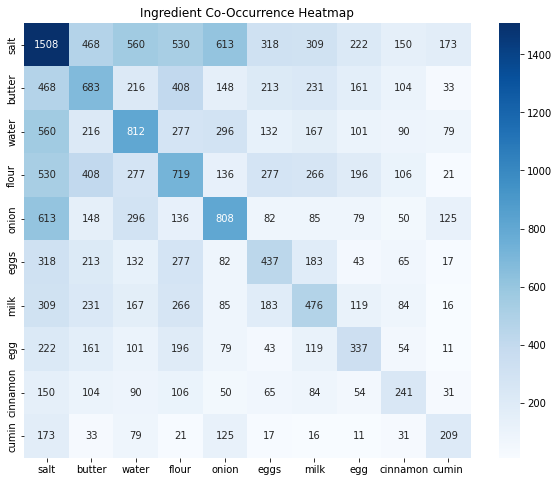

In [83]:
# Ensure only valid ingredients are used
valid_ingredients = [i for i in top_ingredient_names if i in co_matrix_df.index]

# Extract sub-matrix
sub_matrix = co_matrix_df.loc[valid_ingredients, valid_ingredients]

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(sub_matrix, cmap="Blues", annot=True, fmt=".0f")
plt.title("Ingredient Co-Occurrence Heatmap")
plt.show()
